# Camera calibration

In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline

/home/mmayer/anaconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mmayer/anaconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
image_dir = os.path.join('..', 'camera_cal')
image_paths = glob.glob(os.path.join(image_dir, 'calibration*.jpg'))

Let's take a look at an image with the calibration target on it:

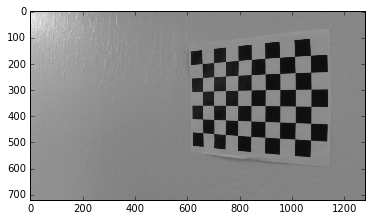

In [3]:
test_img_idx = 2
test_img = cv2.imread(image_paths[test_img_idx])
test_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
plt.imshow(test_gray, cmap='gray');

We find that the calibration target is a 10x7 checkerboard pattern, which gives 9x6 inner corners to detect.

In [4]:
corners_size = 9, 6

Using `findChessboardCorners()` we can detect the specified number of inner corners in the image. The `ret` parameter specifies whether the pattern was successfully detected (which, for the image above, is going to be `True`).

In [5]:
ret, corners = cv2.findChessboardCorners(test_gray, corners_size, None)

Here are the `x` and `y` coordinates of the first corners found. Since the first row is at a upward angle, we expect both the `x` and `y` values to decrease, where the `x` values increase at a much bigger rate than the `y` ones.

In [6]:
print(np.squeeze(corners[:4]))

[[658.3003  203.3237 ]
 [700.4886  200.48181]
 [746.4221  196.44681]
 [793.7218  191.6561 ]]


For the last four coordinates, the `x` values should still increase at about the same rate, however the `y` values are expected to increase due to the line's downward angle.

In [7]:
print(np.squeeze(corners[-4:]))

[[ 896.       483.     ]
 [ 951.58203  485.74704]
 [1009.3205   491.51224]
 [1071.2775   496.41864]]


We can visualize the points and matches using the `drawChessboardCorners()` function, which renders connecting lines since a correct pattern was found (as `ret` is `True`).

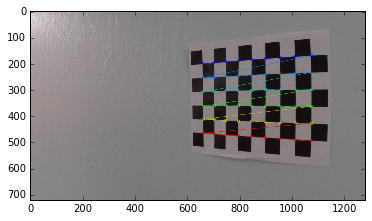

In [8]:
test_img = cv2.drawChessboardCorners(test_img, corners_size, corners, ret)
plt.imshow(test_img);

In order to obtain the camera distortion parameters, we need to correlate the actual coordinates of the corners in the image to the expected, i.e. undistorted, coordinates. Using NumPy's [`mgrid`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mgrid.html) index trick we can create a mesh grid that contains the expected grid coordinates.

In [9]:
grid = np.mgrid[0:3, 0:3]
grid

array([[[0, 0, 0],
        [1, 1, 1],
        [2, 2, 2]],

       [[0, 1, 2],
        [0, 1, 2],
        [0, 1, 2]]])

For example, the coordinate at location (1, 2) is going to be `[1, 2]`.

In [10]:
grid[:, 1, 2]

array([1, 2])

Now the grid has the number of dimensions as the first axis.

In [11]:
grid.shape

(2, 3, 3)

We can also see that the values of the second dimension (the `y`) are increasing faster than the
values of the first dimension (`x`). Since our coordinates are going to be returned in row-major order (i.e. the `x` index changes faster than the `y` index), we need to transpose the grid first.

In [12]:
grid.T.shape

(3, 3, 2)

This serves both the purpose of having the `x`/`y` dimension in the last index, as well as sorting the coordinates along the first row, then followed by the second row, etc.

In [13]:
grid.T.reshape(-1, 2)

array([[0, 0],
       [1, 0],
       [2, 0],
       [0, 1],
       [1, 1],
       [2, 1],
       [0, 2],
       [1, 2],
       [2, 2]])

We can now create a list of expected coordinates for the inner chessboard corners. These are going to be 3D coordinates (X, Y, Z), since both the chessboard and camera were placed in a 3D space. For simplicity, we are going to assume the chessboard was stationary and the camera moved relative to it, which allows us to set the Z coordinate of all expected chessboard edges to be `0`.

In [14]:
# Create an empty array
num_coords = np.prod(corners_size)
objp = np.zeros((num_coords, 3), np.float32)

# Replace the coordinates with the correct ones.
objp[:,:2] = np.mgrid[0:corners_size[0], 0:corners_size[1]].T.reshape(-1,2)

For sanity check, the second edge (index `x=1`) in the third row (index `y=2`) is going to be at index $w\cdot y+x = 9\cdot 2+1 = 19$ for a checkerboard with `w=9` inner edges. The coordinates, as expected, are returned as `x,y,0`:

In [15]:
objp[19]

array([1., 2., 0.], dtype=float32)

For each image, we are going to store the coordinates of the detected points, along with the coordinates of the expected points, in order to automatically find a transformation that will describe the distortion that maps each of the image points into an undistorted coordinate system.

In [16]:
obj_points = []     # 3D points in real world space
img_points = []     # 2D points in image plane
corner_images = []  # Images with overlaid corners for displaying later

for path in image_paths:
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, corners_size, None)
    if ret == False:
        continue
    
    obj_points.append(objp)
    img_points.append(corners)

    # Store the images for later displaying
    img = cv2.drawChessboardCorners(img, corners_size, corners, patternWasFound=True)
    img = cv2.resize(img, (0, 0), fx=0.25, fy=0.25)
    corner_images.append(img)

Here are some of the detected patterns in the first couple of images.

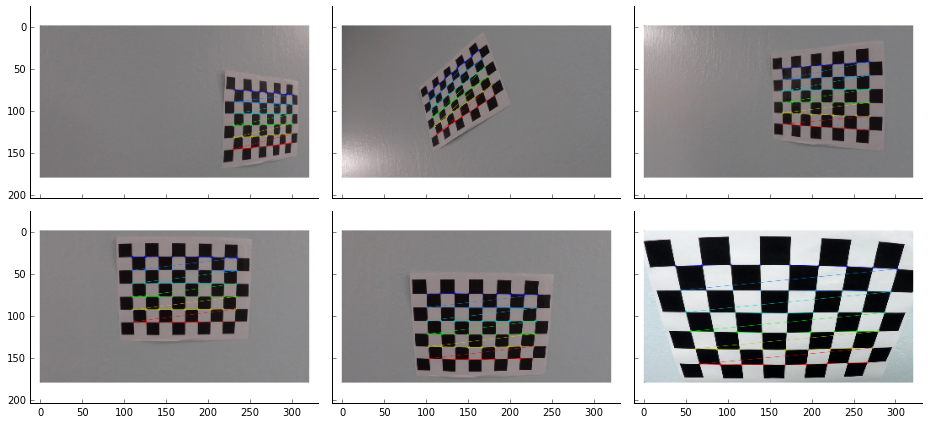

In [17]:
f, axs = plt.subplots(nrows=2, ncols=3, figsize=(13, 6), sharex=True, sharey=True)
for i, ax in enumerate(np.ravel(axs)):
    ax.imshow(corner_images[i])
plt.tight_layout()
sns.despine()

The next stape is to determine the camera parameters that created the distortion in the first place. For this, we need to know the original image size (since the image coordinates only make sense in that space).

In [18]:
image_size = test_gray.shape[::-1]
print(image_size)

(1280, 720)


By passing the (expected) corner coordinates, the actual (distored) image coordinates and the size of the images system, we can obtain the calibration parametes. Since we do not have any prior knowledge about the camera transformation matrix and/or distortion coefficients, we're passing `None` to them.

In [19]:
results = cv2.calibrateCamera(obj_points, img_points, image_size, 
                              cameraMatrix=None, distCoeffs=None)
ret, mtx, dist, rvecs, tvecs = results

The function return values have the following meanings:

- `ret`: The re-projection error
- `mtx`: The estimated camera matrix
- `dist`: The estimated distortion coefficients
- `rvecs`: The estimated rotation vectors for each input pattern
- `tvecs`: The estimation translation vectors for each input pattern

We expect to see some reprojection errors, since the calibration target is not exactly flat.

In [20]:
ret

1.0298151483875213

For the time being however, most of these values are not interesting to us. Most importantly, the `mtx` matrix captures the camera parameters, whereas the `dist` coefficients can be used to undistort an image.
For this, we're going to use the `v2.undistort()` function:

In [21]:
test_undist = cv2.undistort(test_img, mtx, dist, None, mtx)

This is how the results look like:

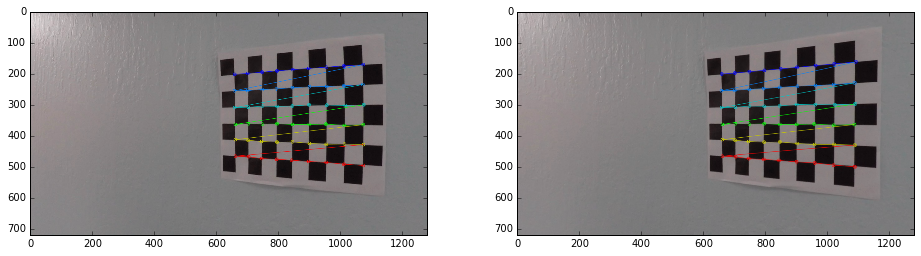

In [22]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
axs[0].imshow(test_img)
axs[1].imshow(test_undist);

As we can see, this removed some of the input pixels from the image. If this is not wanted, we can call `cv2.getOptimalNewCameraMatrix()` which takes a tuning parameter `alpha` determining how much of the original image should be represented in the undistorted image. When set to `1`, every source image is kept at the cost of an addition of black border pixels where no information existed in the first place.

In [23]:
alpha = 1
refined_mtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, image_size, alpha, image_size)

We can now use the refined matrix _in addition_ to the original matrix to obtain an image that does not discard any information:

In [24]:
test_undist = cv2.undistort(test_img, mtx, dist, None, refined_mtx)

We can also overlay a region of interest containing only "good" pixels after refinement. Here's how that looks like:

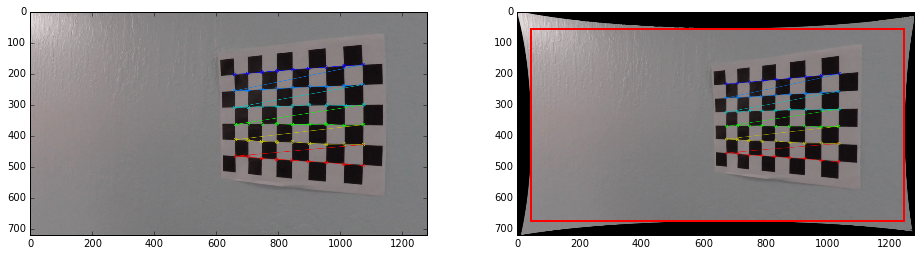

In [25]:
rect = patches.Rectangle(xy=roi[0:2], width=roi[2], height=roi[3],
                        linewidth=2, edgecolor='r', fill=False)

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
axs[0].imshow(test_img)
axs[1].imshow(test_undist)
axs[1].add_patch(rect);

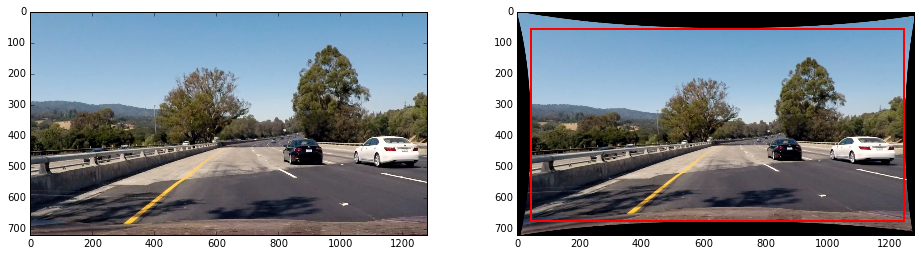

In [33]:
test_img = cv2.imread(os.path.join('..', 'test_images', 'test4.jpg'))
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_undist = cv2.undistort(test_img, mtx, dist, None, refined_mtx)

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
axs[0].imshow(test_img)
axs[1].imshow(test_undist);

rect = patches.Rectangle(xy=roi[0:2], width=roi[2], height=roi[3],
                        linewidth=2, edgecolor='r', fill=False)
axs[1].add_patch(rect);

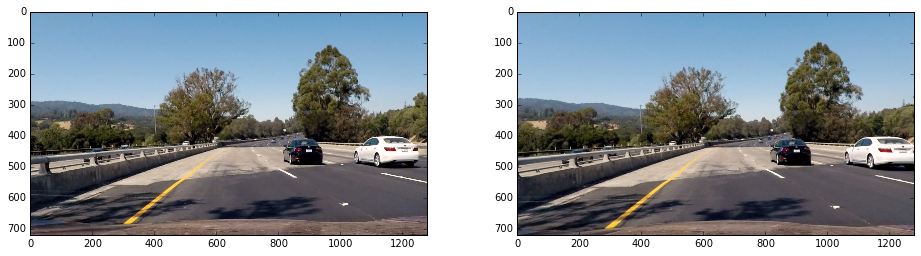

In [34]:
test_undist = cv2.undistort(test_img, mtx, dist, None, mtx)

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
axs[0].imshow(test_img)
axs[1].imshow(test_undist);